In [1]:
import datetime
import numpy as np
import pandas as pd
import os
from scipy.io import loadmat
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import Dataset,DataLoader

# hyperparameters

In [2]:
# hyper
features = ['SOH','voltage_measured', 'current_measured',
            'temperature_measured', 'current_load', 'voltage_load', 'time']
batch_size = 1
input_size = len(features)
hidden_size = 64
num_layers = 1
output_size = 1
seq_len = 50   # 预测序列长度
epoch = 50
learning_rate = 0.001

save_path = 'lstm_seq50.pth'
train_directory = '../datasets/train/'
test_directory = '../datasets/test/'

# 1.Data preprocess

## 1.1 Load Data from mat

In [3]:
def load_data(battery_path):
    # mat = loadmat('../datasets/BatteryDataset/' + battery_id + '.mat') # MAT PATH ESSENTIAL origin
    battery_id = battery_path[-9:-4]
    mat = loadmat(battery_path) # MAT PATH ESSENTIAL

    counter = 0
    dataset = []
    capacity_data = []
    # print('Total data in dataset: ', len(mat[battery][0, 0]['cycle'][0])) #total cycle

    for i in range(len(mat[battery_id][0, 0]['cycle'][0])):
        row = mat[battery_id][0, 0]['cycle'][0, i]
        if row['type'][0] == 'discharge':
            ambient_temperature = row['ambient_temperature'][0][0]
            date_time = datetime.datetime(int(row['time'][0][0]),
                                          int(row['time'][0][1]),
                                          int(row['time'][0][2]),
                                          int(row['time'][0][3]),
                                          int(row['time'][0][4])) + datetime.timedelta(seconds=int(row['time'][0][5]))
            data = row['data']
            capacity = data[0][0]['Capacity'][0][0]
            for j in range(len(data[0][0]['Voltage_measured'][0])):
                voltage_measured = data[0][0]['Voltage_measured'][0][j]
                current_measured = data[0][0]['Current_measured'][0][j]
                temperature_measured = data[0][0]['Temperature_measured'][0][j]
                current_load = data[0][0]['Current_load'][0][j]
                voltage_load = data[0][0]['Voltage_load'][0][j]
                time = data[0][0]['Time'][0][j]
                dataset.append([counter + 1, ambient_temperature, date_time, capacity,
                                voltage_measured, current_measured,temperature_measured,
                                current_load, voltage_load, time])

            capacity_data.append([counter + 1, ambient_temperature, date_time, capacity,
                                  voltage_measured, current_measured,temperature_measured,
                                  current_load, voltage_load, time])
            counter = counter + 1
    # print(dataset[0])

    return [pd.DataFrame(data=dataset,
                         columns=['cycle', 'ambient_temperature', 'datetime','capacity',
                                  'voltage_measured','current_measured', 'temperature_measured',
                                  'current_load', 'voltage_load', 'time']),
            pd.DataFrame(data=capacity_data,
                         columns=['cycle', 'ambient_temperature', 'datetime','capacity',
                                  'voltage_measured','current_measured', 'temperature_measured',
                                  'current_load', 'voltage_load', 'time'])]



# dataset, capacity = load_data('B0005')
# capacity.to_csv('../datasets/BatteryCSV/B0005cap.csv', index=False)
# pd.set_option('display.max_columns', 10)
# print(capacity.head(5))
# dataset.describe()



## 1.2 normlize data

In [4]:
def norm_data(battery_id):
    dataset, capacity = load_data(battery_id)
    C = capacity['capacity'][0]
    soh = []
    for i in range(len(capacity)):
        soh.append([capacity['capacity'][i] / C])
    soh = pd.DataFrame(data=soh, columns=['SOH'])

    # features for training
    attribs=['voltage_measured', 'current_measured',
             'temperature_measured', 'current_load', 'voltage_load', 'time']
    train_dataset = capacity[attribs]
    sc = MinMaxScaler(feature_range=(0,1)) # = (num-min)/(max-min)
    train_dataset = sc.fit_transform(train_dataset) # issue：not based on Rated
    # print(train_dataset.shape)
    # print(soh.shape)
    attribs_scaled = pd.DataFrame(data=train_dataset,columns=attribs)
    return  pd.concat([capacity['cycle'], attribs_scaled, soh], axis=1)

def data_loader(battery_id, seq_len, features):
    dataset = norm_data(battery_id)
    input_size = len(features)
    data_set_train=dataset[features].values
    x_train=[]
    label=[]
    batch = len(data_set_train)
    #take the last 10t to predict 10t+1
    for i in range (seq_len,batch):
        x_train.append(data_set_train[i-seq_len:i,:])
        label.append(data_set_train[i,0])

    x_train = np.array(x_train)
    x_train = np.reshape(x_train,(batch-seq_len,seq_len,input_size)) #(batch,seq_len,input_size)
    x_train = torch.tensor(x_train, dtype=torch.float32)
    label = torch.tensor(label, dtype=torch.float32).view(-1, 1) # (batch,seq_len)取最后一个输出
    return x_train, label

# # storge
# features = ['SOH','voltage_measured', 'current_measured',
#             'temperature_measured', 'current_load', 'voltage_load', 'time']
# train_data,train_data_real = data_loader('B0005', 10 , features)
# train_data,train_data_real
# dataset_scaled.to_csv('../datasets/BatteryCSV/B0005norm.csv', index=False)

## 1.3 dataloader

In [5]:
class LoadDataset(Dataset):
    def __init__(self, root_dir, seq_len, features,  transform=None):
        self.root_dir = root_dir
        self.seq_len  = seq_len
        self.features = features
        self.transform = transform
        self.file_list = sorted(os.listdir(root_dir))  # Assumes file names determine order

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        battery_id = self.file_list[idx]
        battery_path = os.path.join(self.root_dir, battery_id)
        dataset, label = data_loader(battery_path, self.seq_len, self.features)

        # battery_id = self.file_list[idx][:-4]
        # dataset, label = data_loader(battery_id, self.seq_len, self.features)

        # if self.transform:
        #     dataset = self.transform(dataset)
        #     label = self.transform(label)

        return dataset, label


# # Example usage
# custom_dataset = LoadDataset(train_directory, seq_len=seq_len, features=features)
#
# # Create DataLoader
# dataloader = DataLoader(custom_dataset, batch_size=batch_size)
#
# for train_data, train_data_real in dataloader:
#     train_data_real=torch.squeeze(train_data_real)
#     print(train_data_real.shape)

## 2. training
class torch.nn.LSTM(*args, **kwargs)
参数有：
    input_size：x的特征维度
    hidden_size：隐藏层的特征维度
    num_layers：lstm隐层的层数，默认为1
    bias：False则bihbih=0和bhhbhh=0. 默认为True
    batch_first：True则输入输出的数据格式为 (batch, seq_len, feature)
    dropout：除最后一层，每一层的输出都进行dropout，默认为: 0
    bidirectional：True则为双向lstm默认为False

LSTM input(seq_len, batch, input_size)
参数有：
    batch：每次喂给网络的数据条数，在NLP中就是一次喂给网络多少个句子 !!!
    seq_len：序列长度，在NLP中就是句子长度，一般都会用pad_sequence补齐长度!!!
    input_size：特征维度，和前面定义网络结构的input_size一致。

output,(ht, ct) = net(input)
    output: 最后一个状态的隐藏层的神经元输出 size = （seq_Len, batch, num_directions * hidden_size)
    ht：最后一个状态的隐含层的状态值
    ct：最后一个状态的隐含层的遗忘门值



In [6]:
# net structure
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.lstm1 = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.lstm2 = nn.LSTM(hidden_size, hidden_size, num_layers, batch_first=True)
        self.lstm3 = nn.LSTM(hidden_size, hidden_size, num_layers, batch_first=True)
        self.lstm4 = nn.LSTM(hidden_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm1(x) # shape（seq_Len, batch, num_directions * hidden_size)
        out, _ = self.lstm2(out)
        out, _ = self.lstm3(out)
        out, _ = self.lstm4(out)
        out = self.fc(out[:, -1, :])  # 使用最后一个时间步的输出的输入（seq_Len, batch, num_directions * hidden_size)
        # print(out.shape)
        return out


In [7]:
# train
if __name__ == "__main__":
    # checking if GPU is available
    device = torch.device("cpu")
    if (torch.cuda.is_available()):
        device = torch.device("cuda:0")
        print('Training on GPU.')
    else:
        print('No GPU available, training on CPU.')

    # 构建模型
    model = LSTMModel(input_size=input_size,
                      hidden_size=hidden_size,
                      output_size=output_size,
                      num_layers = num_layers)
    # model = model.to(device) # lstm doesnt work on gpu?
    # dataset
    train_dataset = LoadDataset(train_directory, seq_len=seq_len, features=features)
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
    # #vailidation
    # validation_data, validation_data_real = data_loader('B0006',seq_len,features)

    # 定义损失函数和优化器
    criterion = nn.MSELoss()
    # criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # 储存路径
    work_dir = './LSTM'
    # 添加tensorboard
    writer = SummaryWriter("{}/logs".format(work_dir))

    # model = model.to(device)
    criterion = criterion.to(device)

    # 训练模型
    for epoch in range(epoch):
        print("-------epoch  {} -------".format(epoch+1))
        # 训练步骤
        model.train()
        train_loss = 0
        for train_data, train_data_real in train_dataloader:
            train_data = torch.squeeze(train_data)
            train_data_real = torch.squeeze(train_data_real)

            output = model(train_data)
            output = torch.squeeze(output)
            loss = criterion(output, train_data_real)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss = train_loss + loss.item()
        print("train set Loss: {}".format(train_loss/len(train_dataloader)))

        # 测试步骤
        model.eval()
        total_test_loss = 0
        total_accuracy = 0
        # with torch.no_grad():#用于在推断或验证阶段，当不需要计算梯度时，以提高效率和减少内存占用
        #     test_outputs = model(validation_data)
        #     loss = criterion(test_outputs, validation_data_real)
        #     # total_test_loss = total_test_loss + loss.item()
        #     # accuracy = (outputs.argmax(1) == targets).sum()
        #     # total_accuracy = total_accuracy + accuracy
        # print("test set Loss: {}".format(loss.item()))
    # Save the trained model
    torch.save(model.state_dict(), save_path)

Training on GPU.
-------epoch  1 -------


NotImplementedError: Could not run 'aten::mkldnn_rnn_layer' with arguments from the 'CUDA' backend. This could be because the operator doesn't exist for this backend, or was omitted during the selective/custom build process (if using custom build). If you are a Facebook employee using PyTorch on mobile, please visit https://fburl.com/ptmfixes for possible resolutions. 'aten::mkldnn_rnn_layer' is only available for these backends: [CPU, Meta, BackendSelect, Python, FuncTorchDynamicLayerBackMode, Functionalize, Named, Conjugate, Negative, ZeroTensor, ADInplaceOrView, AutogradOther, AutogradCPU, AutogradCUDA, AutogradHIP, AutogradXLA, AutogradMPS, AutogradIPU, AutogradXPU, AutogradHPU, AutogradVE, AutogradLazy, AutogradMeta, AutogradMTIA, AutogradPrivateUse1, AutogradPrivateUse2, AutogradPrivateUse3, AutogradNestedTensor, Tracer, AutocastCPU, AutocastCUDA, FuncTorchBatched, FuncTorchVmapMode, Batched, VmapMode, FuncTorchGradWrapper, PythonTLSSnapshot, FuncTorchDynamicLayerFrontMode, PythonDispatcher].

CPU: registered at C:\cb\pytorch_1000000000000\work\build\aten\src\ATen\RegisterCPU.cpp:31034 [kernel]
Meta: registered at /dev/null:228 [kernel]
BackendSelect: fallthrough registered at C:\cb\pytorch_1000000000000\work\aten\src\ATen\core\BackendSelectFallbackKernel.cpp:3 [backend fallback]
Python: registered at C:\cb\pytorch_1000000000000\work\aten\src\ATen\core\PythonFallbackKernel.cpp:144 [backend fallback]
FuncTorchDynamicLayerBackMode: registered at C:\cb\pytorch_1000000000000\work\aten\src\ATen\functorch\DynamicLayer.cpp:491 [backend fallback]
Functionalize: registered at C:\cb\pytorch_1000000000000\work\aten\src\ATen\FunctionalizeFallbackKernel.cpp:280 [backend fallback]
Named: registered at C:\cb\pytorch_1000000000000\work\aten\src\ATen\core\NamedRegistrations.cpp:7 [backend fallback]
Conjugate: registered at C:\cb\pytorch_1000000000000\work\aten\src\ATen\ConjugateFallback.cpp:17 [backend fallback]
Negative: registered at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\NegateFallback.cpp:19 [backend fallback]
ZeroTensor: registered at C:\cb\pytorch_1000000000000\work\aten\src\ATen\ZeroTensorFallback.cpp:86 [backend fallback]
ADInplaceOrView: fallthrough registered at C:\cb\pytorch_1000000000000\work\aten\src\ATen\core\VariableFallbackKernel.cpp:63 [backend fallback]
AutogradOther: registered at C:\cb\pytorch_1000000000000\work\torch\csrc\autograd\generated\VariableType_2.cpp:17476 [autograd kernel]
AutogradCPU: registered at C:\cb\pytorch_1000000000000\work\torch\csrc\autograd\generated\VariableType_2.cpp:17476 [autograd kernel]
AutogradCUDA: registered at C:\cb\pytorch_1000000000000\work\torch\csrc\autograd\generated\VariableType_2.cpp:17476 [autograd kernel]
AutogradHIP: registered at C:\cb\pytorch_1000000000000\work\torch\csrc\autograd\generated\VariableType_2.cpp:17476 [autograd kernel]
AutogradXLA: registered at C:\cb\pytorch_1000000000000\work\torch\csrc\autograd\generated\VariableType_2.cpp:17476 [autograd kernel]
AutogradMPS: registered at C:\cb\pytorch_1000000000000\work\torch\csrc\autograd\generated\VariableType_2.cpp:17476 [autograd kernel]
AutogradIPU: registered at C:\cb\pytorch_1000000000000\work\torch\csrc\autograd\generated\VariableType_2.cpp:17476 [autograd kernel]
AutogradXPU: registered at C:\cb\pytorch_1000000000000\work\torch\csrc\autograd\generated\VariableType_2.cpp:17476 [autograd kernel]
AutogradHPU: registered at C:\cb\pytorch_1000000000000\work\torch\csrc\autograd\generated\VariableType_2.cpp:17476 [autograd kernel]
AutogradVE: registered at C:\cb\pytorch_1000000000000\work\torch\csrc\autograd\generated\VariableType_2.cpp:17476 [autograd kernel]
AutogradLazy: registered at C:\cb\pytorch_1000000000000\work\torch\csrc\autograd\generated\VariableType_2.cpp:17476 [autograd kernel]
AutogradMeta: registered at C:\cb\pytorch_1000000000000\work\torch\csrc\autograd\generated\VariableType_2.cpp:17476 [autograd kernel]
AutogradMTIA: registered at C:\cb\pytorch_1000000000000\work\torch\csrc\autograd\generated\VariableType_2.cpp:17476 [autograd kernel]
AutogradPrivateUse1: registered at C:\cb\pytorch_1000000000000\work\torch\csrc\autograd\generated\VariableType_2.cpp:17476 [autograd kernel]
AutogradPrivateUse2: registered at C:\cb\pytorch_1000000000000\work\torch\csrc\autograd\generated\VariableType_2.cpp:17476 [autograd kernel]
AutogradPrivateUse3: registered at C:\cb\pytorch_1000000000000\work\torch\csrc\autograd\generated\VariableType_2.cpp:17476 [autograd kernel]
AutogradNestedTensor: registered at C:\cb\pytorch_1000000000000\work\torch\csrc\autograd\generated\VariableType_2.cpp:17476 [autograd kernel]
Tracer: registered at C:\cb\pytorch_1000000000000\work\torch\csrc\autograd\generated\TraceType_2.cpp:16726 [kernel]
AutocastCPU: registered at C:\cb\pytorch_1000000000000\work\aten\src\ATen\autocast_mode.cpp:492 [kernel]
AutocastCUDA: fallthrough registered at C:\cb\pytorch_1000000000000\work\aten\src\ATen\autocast_mode.cpp:354 [backend fallback]
FuncTorchBatched: registered at C:\cb\pytorch_1000000000000\work\aten\src\ATen\functorch\LegacyBatchingRegistrations.cpp:815 [backend fallback]
FuncTorchVmapMode: fallthrough registered at C:\cb\pytorch_1000000000000\work\aten\src\ATen\functorch\VmapModeRegistrations.cpp:28 [backend fallback]
Batched: registered at C:\cb\pytorch_1000000000000\work\aten\src\ATen\LegacyBatchingRegistrations.cpp:1073 [backend fallback]
VmapMode: fallthrough registered at C:\cb\pytorch_1000000000000\work\aten\src\ATen\VmapModeRegistrations.cpp:33 [backend fallback]
FuncTorchGradWrapper: registered at C:\cb\pytorch_1000000000000\work\aten\src\ATen\functorch\TensorWrapper.cpp:210 [backend fallback]
PythonTLSSnapshot: registered at C:\cb\pytorch_1000000000000\work\aten\src\ATen\core\PythonFallbackKernel.cpp:152 [backend fallback]
FuncTorchDynamicLayerFrontMode: registered at C:\cb\pytorch_1000000000000\work\aten\src\ATen\functorch\DynamicLayer.cpp:487 [backend fallback]
PythonDispatcher: registered at C:\cb\pytorch_1000000000000\work\aten\src\ATen\core\PythonFallbackKernel.cpp:148 [backend fallback]


# 3.eval and plot comparation

C:\Users\CC\AppData\Local\Temp\ipykernel_6404\2718649619.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_data = torch.tensor(test_data, dtype=torch.float32)


(118,)


Text(0.5, 1.0, 'Discharge B0006')

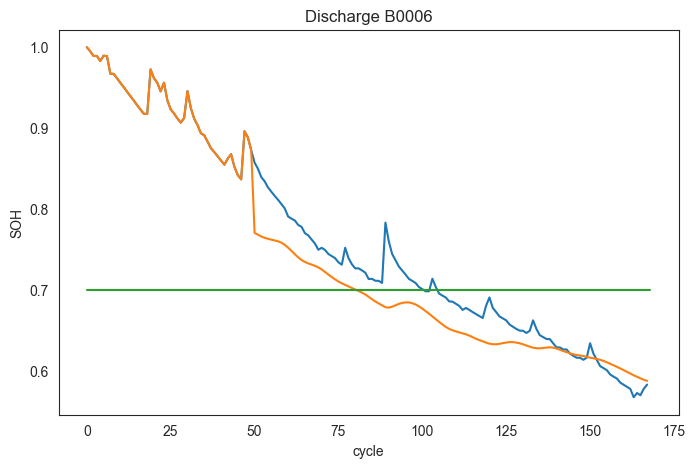

In [19]:
test_battery_id = 'B0006'
test_battery_path = test_directory+ test_battery_id + '.mat'
test_data,test_data_real = data_loader(test_battery_path,seq_len,features)
input_data = torch.tensor(test_data, dtype=torch.float32)
# load
lstm = LSTMModel(input_size=input_size, hidden_size=hidden_size, output_size=output_size, num_layers=num_layers)
lstm.load_state_dict(torch.load(save_path))
lstm.eval()
output = lstm(input_data)
predicted_data = output.detach().numpy().reshape(-1)
print(predicted_data.shape)


# draw
origin_data = norm_data(test_battery_path) # dictionary
sns.set_style("white")
plt.figure(figsize=(8, 5))
#Draw
# plt.plot([i for i in range(len(origin_data['SOH'][seq_len:]))], origin_data['SOH'][seq_len:], label='SOH')
# plt.plot([i for i in range(len(test_data))], predicted_data, label='Predicted SOH')
plt.plot([i for i in range(len(origin_data['SOH']))], origin_data['SOH'], label='SOH')
predicted_data = np.concatenate((origin_data['SOH'][0:seq_len],predicted_data), axis = 0)
plt.plot([i for i in range(len(origin_data['SOH']))], predicted_data, label='Predicted SOH')
plt.plot([0.,len(origin_data['SOH'])], [0.70, 0.70], label='Threshold')

# make x-axis ticks legible
adf = plt.gca().get_xaxis().get_major_formatter()
plt.xlabel('cycle')
plt.ylabel('SOH')
plt.title('Discharge {}'.format(test_battery_id))